In [177]:
import platform

global systemDivide
if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

In [178]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)

initParameters = {
    'yThreshold': 200,
    'rollingMean': 1000,
    'fatRollingMean': 3000,
    'timeBarrier': 1900,
    'varianceRatioFilter': 1.1,
    'restAfterLoss': 350,
    'restAfterFatProfit' : 350,
    'stopLossPercent': 3,
    'takeProfitPercent': 20,
    'varianceRatioCarreteParameter': 40,
    }
# initParameters = {
#     'yThreshold': 240,
#     'rollingMean': 600,
#     'fatRollingMean': 1800,
#     'timeBarrier': 800,
#     'varianceRatioFilter': 1.0,
#     'restAfterLoss': 150,
#     'restAfterFatProfit' : 50,
#     'stopLossPercent': .25,
#     'takeProfitPercent': 10,
#     'varianceRatioCarreteParameter': 10,
#     }

# Проверим распределение доходностей на нормальность

3 sigma anomalies 1.275%


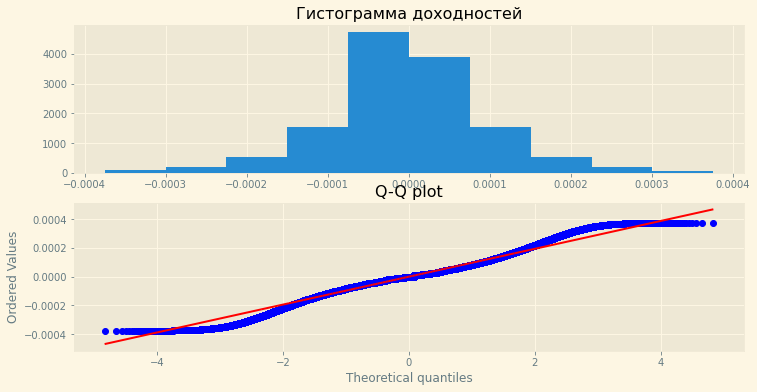

In [179]:
import matplotlib.pylab as plt
from scipy.stats import zscore, probplot

plt.style.use(style='fast')
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('Гистограмма доходностей')
abs_Z_scores = np.abs(zscore(inpData.open.pct_change().iloc[1:]))
filtered = (abs_Z_scores < 3)
print(f'3 sigma anomalies {(1 - sum(filtered) / inpData.shape[0]):.3%}')
bars = plt.hist(inpData.open.pct_change().values[1:][filtered], density=True, )
ax = plt.subplot(2,1,2)

probplot(inpData.open.pct_change().values[1:][filtered], plot=ax)
plt.title(f'Q-Q plot')
plt.show()
del abs_Z_scores, filtered, bars

In [180]:
def create_grid(params: initParameters):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = .2
    retParams = {
        # Капитал
        'capital': capital,
        # Можно использовать для стоп лоссов и тейков с учетом слипэджа
        'slippagePerCapital': slippage / capital,
        # То какой размах мы будем брать для построения полос Боллинджера. Это и есть X Threshold из файла Евгения
        'yThreshold': round(params['yThreshold'] / 100, 2),
        # Период за который мы строим малую скользяшку
        'rollingMean': params['rollingMean'],
        # Период за который мы строим большую скользяшку
        'fatRollingMean': params['fatRollingMean'],
        # Временной барьер, Максимальное время сколько мы можем держать позицию
        'timeBarrier': params['timeBarrier'],
        # Параметр для определения того что данные MeanReversion/TrendFollowing
        # Используется в VRratio тестах для открытия/удержания позиции
        'varianceRatioFilter': params['varianceRatioFilter'],
        # Сколько времени мы не торгуем после срабатывания стоп лосса
        'restAfterLoss': params['restAfterLoss'],
        # Сколько времени мы не торгуем после закрытия позиции о большую скользяшку
        'restAfterFatProfit' : params['restAfterFatProfit'],
        # Процент стоп лосса
        'stopLossThreshold': round(params['stopLossPercent'] / 100, 3),
        # Процент тэйк профита
        'takeProfitThreshold': round(params['takeProfitPercent'] / 100, 3),
        # Тот период за который мы будем считать Variance Ratio. Те ставя тут к примеру 1500, мы должны будем передавать в функцию
        # VR Ratio 1500 точек данных. Сейчас этот гипермараметр связан с гиперпараметров периода малой скользяшки
        'varianceLookBack': params['rollingMean'] * 2,
        # Чему будет равен временной лаг Q; Q = varianceLookBack // PARAM + 1
        'varianceRatioCarrete': int((params['rollingMean'] * 2) // params['varianceRatioCarreteParameter']) + 1,
    }
    return retParams

def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['HBBand'] = df['rollMean'] + df['rollingStd'] * params['yThreshold']
    df['LBBand'] = df['rollMean'] - df['rollingStd'] * params['yThreshold']
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[max(params['varianceLookBack'], params['fatRollingMean']):]

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))

    sigma_b = (1 / m) * _buff_
    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(logTuple: tuple, retTuple: tuple, params: dict, timeBorderCounter: int) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    if timeBorderCounter < params["varianceLookBack"]:
        buffer_size = len(retTuple)
        means = (1 / buffer_size) * np.sum(retTuple)
        # сдвиг во времени q
        m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
        sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
        subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
        _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        if result > params['varianceRatioFilter']:
            return True
        else:
            return False
    else:
        return False


def open_position(arrowIndex, recursionFilter, LBandTuple, HBandTuple, LowTuple,
                 HighTuple, OpenTuple, params, logTuple, retTuple) -> dict:
    """
    Возвращает список с типом сделанной сделки
    Для всех параметров заканчивающихся на Tuple верно следующее: передается как массив tuple.
    Это связанно с повышением эффективности бэктеста и особенностями рекурсии. В real-time будет другая реализация

    :param arrowIndex: Навигация по полному массиву данных. В real-time не нужен
    :param recursionFilter: ограничитель ошибок связанных с забитием памяти и превышением лимита рекурсии. В real-time не нужен
    :param LBandTuple: нижняя граница болинджера. Цена посчитанная как actualLightMean - std * {HYPERPARAMETER}
    :param HBandTuple: верхняя полоса болинджера. Цена посчитанная как actualLightMean + std * {HYPERPARAMETER}.
    :param LowTuple: low цена. В real-time скорее всего будет неактуально
    :param HighTuple: high цена. В real-time скорее всего будет неактуально
    :param OpenTuple: open цена. В real-time скорее всего будет неактуально
    :param params: список параметров полученных с помощью create_grid
    :param logTuple: необходим для расчета Variance ratio. Логарифмированные цены
    :param retTuple: необходим для расчета Variance ratio. Возвраты во времени
    :return: список о сделанной сделке. Нужен такой тип для сокращения возможности ошибки.
    """
    LOGIC_BOOL = False
    _recursion_limit = 10_000

    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    # if нужный для корректной работы нашей конерктной реализации. Мы работаем через рекурсию, поэтому это нужно для того
    # Чтобы не вызывать StackOverflow
    if recursionFilter > _recursion_limit:
        return arrowIndex

    # Проверяем находится ли цена открытия бара выше чем нижняя полоса Боллинджера. Нужно так делать только для бэкстеста
    # Суть в том, что так мы защищаться от возможности ситуации когда все цены находятся находятся ниже полосы из-за например резкого ГЭПА
    # Соответствует сделке о покупке. Проверяем что цена LOW находится ниже нижней полосы Боллинджера.
    # В real-time нужно будет считать HBandTuple[arrowIndex] динамически в зависимости от данных что уже есть
    if (OpenTuple[arrowIndex] > LBandTuple[arrowIndex]) and (LowTuple[arrowIndex] < LBandTuple[arrowIndex]):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = params['capital'] / LBandTuple[arrowIndex]
            openDict['openPrice'] = LBandTuple[arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = LBandTuple[arrowIndex] * (1 - params['stopLossThreshold'])
            openDict['takeProfitBorder'] = LBandTuple[arrowIndex] * (1 + params['takeProfitThreshold'])
            LOGIC_BOOL = True
            return openDict

    # Проверяем находится ли цена открытия бара выше чем нижняя полоса Боллинджера. Соответствует сделке о продаже
    # В real-time нужно будет считать HBandTuple[arrowIndex] динамически в зависимости от данных что уже есть
    elif (OpenTuple[arrowIndex] < HBandTuple[arrowIndex]) and (HighTuple[arrowIndex] > HBandTuple[arrowIndex]):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = -1 * (params['capital'] / HBandTuple[arrowIndex])
            openDict['openPrice'] = HBandTuple[arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = HBandTuple[arrowIndex] * (1 + params['stopLossThreshold'])
            openDict['takeProfitBorder'] = HBandTuple[arrowIndex] * (1 - params['takeProfitThreshold'])
            LOGIC_BOOL = True
            return openDict

    # В случае, если сделку открыть не получилось, переходим к следующей точке. Вывод - пока что сделку не получилось
    # В real-time это является аналогом ожидания до появления следующих данных и повторения проверки на открытие уже на них
    if not LOGIC_BOOL:
        return open_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1, LBandTuple=LBandTuple,
                     HBandTuple=HBandTuple, LowTuple=LowTuple, HighTuple=HighTuple, OpenTuple=OpenTuple, params=params,
                     logTuple=logTuple, retTuple=retTuple)


def close_position(arrowIndex, recursionFilter, openDict, LowTuple, HighTuple, OpenTuple, LightMeanTuple, FatMeanTuple,
                   params, logTuple, retTuple, timeBorderCounter, indicatorVR) -> dict:
    """
    Определяет логику закрытия позиции. Содержит в себе закрытие по Stop_Loss, time_border, закрытие о быстрое скользящее,
    закрытие о долгое скользящее

    Для всех параметров заканчивающихся на Tuple верно следующее: передается как массив tuple.
    Это связанно с повышением эффективности бэктеста и особенностями рекурсии. В real-time будет другая реализация
    :param arrowIndex: Указатель необходимый для перемещения. В real-time не нужен
    :param recursionFilter: Указатель необходимый для работы с рекурсией. В real-time не нужен
    :param openDict: Список состоящий из условий открытия сделки
    :param LowTuple: low цена. В real-time скорее всего будет неактуально
    :param HighTuple: high цена. В real-time скорее всего будет неактуально
    :param OpenTuple: open цена. В real-time скорее всего будет неактуально
    :param LightMeanTuple: скользящее среднее за меньший период
    :param FatMeanTuple: скользящее среднее за больший период
    :param params: тут передаются все гиперпараметры стратегии
    :param logTuple: логарифмированные цены
    :param retTuple: возвраты за историю
    :param timeBorderCounter: счетчик необходимый для возможности закрытия о time-barrier
    :param indicatorVR: логическая величина позволяющая гибко добавлять смену режимов стратегии
    Фактически показывает в каком сейчас режиме работает логика удержания позиции. Достаточно легко добавляется сейчас
    следующие режимы
    1) Попытка закрыться не о скользящее среднее за меньший период, а за больший. Повышает прибыльность одной сделки
    2) Позволяет из режима 1) переходить в нулевой, например когда Variance Ratio с тайм-лагом q=Сколько мы находимся в сделке
    Показывает что данные поменяли тенденцию с meanReversion на TrendFollowing
    :return:
    """
    _recursion_limit = 10_000
    NOT_NONE_SAVER = False

    # Условия для корректной работы рекурсии
    if recursionFilter > _recursion_limit:
        return [arrowIndex, indicatorVR]

    # Условия для закрытие о time-barrier
    if timeBorderCounter >= params['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': OpenTuple[arrowIndex+1],
                        'closeIndex': arrowIndex+1}

    # Условия удержания позиции если мы ставли в ЛОНГ
    elif openDict['typeOperation'] == 'BUY':
        # Стоп лосс условие
        if LowTuple[arrowIndex] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!
        elif (OpenTuple[arrowIndex] < LightMeanTuple[arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if HighTuple[arrowIndex] > LightMeanTuple[arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if LightMeanTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                    if not reverse_variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=retTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                                              retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                                              indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if OpenTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                # Аналогично тому что было раньше
                if HighTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': FatMeanTuple[arrowIndex],
                            'closeIndex': arrowIndex}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                    indicatorVR = False
    """================================================================================="""
    # Все аналогично, не считая симмертричность
    if openDict['typeOperation'] == 'SELL':
        # Stop Loss
        if HighTuple[arrowIndex] > openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой
        elif (OpenTuple[arrowIndex] > LightMeanTuple[arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть шорт о пересечение с малой скользящей
            if LowTuple[arrowIndex] < LightMeanTuple[arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции
                if LightMeanTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                    if not reverse_variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=retTuple[arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                                              retTuple=retTuple, timeBorderCounter=timeBorderCounter+1,
                                              indicatorVR=True)

                    else:
                        # small MA
                        return {'typeHolding': 'lightCross', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # emergent exit
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': LightMeanTuple[arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Ждем пересечение с толстой скользящей
        if indicatorVR:
            if OpenTuple[arrowIndex] > FatMeanTuple[arrowIndex]:
                if LowTuple[arrowIndex] < FatMeanTuple[arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': FatMeanTuple[arrowIndex],
                            'closeIndex': arrowIndex}
                if variance_ratio(logTuple=logTuple[arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=retTuple[arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                    indicatorVR = False



    if not NOT_NONE_SAVER:
        return close_position(arrowIndex=arrowIndex + 1, recursionFilter=recursionFilter + 1,
                              openDict=openDict, LowTuple=LowTuple, HighTuple=HighTuple,
                              OpenTuple=OpenTuple, LightMeanTuple=LightMeanTuple,
                              FatMeanTuple=FatMeanTuple, params=params, logTuple=logTuple,
                              retTuple=retTuple, timeBorderCounter=timeBorderCounter + 1,
                              indicatorVR=indicatorVR)



# Начиная с этого момента просто запускается стратегия в парадигме рекурсии
startParams = create_grid(initParameters)
cookedData = cook_data(df=inpData.copy(), params=startParams)

RESULT = list()
openPOS = open_position(arrowIndex=startParams['varianceLookBack'], recursionFilter=0, LBandTuple=cookedData.LBBand, HBandTuple=cookedData.HBBand,
             LowTuple=cookedData.low, HighTuple=cookedData.high, OpenTuple=cookedData.open , params=startParams,
             logTuple=cookedData.logOpenPrice, retTuple=cookedData.retOpenPrice)

closePos = close_position(arrowIndex=openPOS['openIndex'], recursionFilter=0, openDict=openPOS, LowTuple=cookedData.low,
                          HighTuple=cookedData.high, OpenTuple=cookedData.open, LightMeanTuple=cookedData.rollMean,
                          FatMeanTuple=cookedData.fatMean, params=startParams, logTuple=cookedData.logOpenPrice,
                          retTuple=cookedData.retOpenPrice, timeBorderCounter=0, indicatorVR=False)
RESULT.append({**openPOS, **closePos})
openPOS = startParams['varianceLookBack'] + closePos['closeIndex']
for i in tqdm(range(450)):
    while type(openPOS) is not dict:
            openPOS = open_position(arrowIndex=openPOS, recursionFilter=0, LBandTuple=cookedData.LBBand, HBandTuple=cookedData.HBBand,
             LowTuple=cookedData.low, HighTuple=cookedData.high, OpenTuple=cookedData.open , params=startParams,
             logTuple=cookedData.logOpenPrice, retTuple=cookedData.retOpenPrice)

    closePos = int(openPOS['openIndex'] + 1)
    indicatorVR = False
    while type(closePos) is not dict:
            closePos = close_position(arrowIndex=closePos, recursionFilter=0, openDict=openPOS, LowTuple=cookedData.low,
                              HighTuple=cookedData.high, OpenTuple=cookedData.open, LightMeanTuple=cookedData.rollMean,
                              FatMeanTuple=cookedData.fatMean, params=startParams, logTuple=cookedData.logOpenPrice,
                              retTuple=cookedData.retOpenPrice, timeBorderCounter=0, indicatorVR=indicatorVR)
            if type(closePos) == list:
                indicatorVR = closePos[1]
                closePos = closePos[0]

    total_dict = {**openPOS, **closePos}
    RESULT.append(total_dict)
    openPOS = closePos['closeIndex'] + 1

# RESULT содержит в себе всю нуюную статистику
RESULT = pd.DataFrame(RESULT)

  0%|          | 0/450 [00:00<?, ?it/s]

In [181]:
RESULT[RESULT.typeHolding == 'fatExtraProfit']

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex
4,SELL,-176.698422,113.187202,9758,116.582818,90.549762,fatExtraProfit,112.897755,11104
5,BUY,177.432118,112.719164,11122,109.337589,135.262996,fatExtraProfit,112.921692,11424
11,SELL,-175.775134,113.781736,18563,117.195188,91.025389,fatExtraProfit,113.590289,19313
85,SELL,-180.124684,111.034199,137600,114.365225,88.827359,fatExtraProfit,111.041811,139472
88,SELL,-179.321547,111.531494,144488,114.877438,89.225195,fatExtraProfit,111.447861,144907
91,BUY,179.207303,111.602594,149181,108.254517,133.923113,fatExtraProfit,111.678316,149193
92,SELL,-179.004532,111.729015,149257,115.080885,89.383212,fatExtraProfit,111.669311,149349
93,SELL,-178.991596,111.737090,149408,115.089202,89.389672,fatExtraProfit,111.665072,149429
111,BUY,183.941950,108.729955,179513,105.468057,130.475946,fatExtraProfit,109.018142,180056
116,SELL,-183.803296,108.811977,186898,112.076336,87.049582,fatExtraProfit,108.683871,188506


In [182]:
RESULT[(RESULT.typeOperation == 'BUY') & (RESULT.typeHolding == 'endPeriod')]

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex
1,BUY,176.853158,113.088170,5740,109.695525,135.705804,endPeriod,112.855,7642
18,BUY,176.025118,113.620148,29325,110.211544,136.344178,endPeriod,113.281,31227
26,BUY,175.807397,113.760856,41065,110.348031,136.513028,endPeriod,113.544,42967
27,BUY,176.397083,113.380560,43112,109.979143,136.056672,endPeriod,113.035,45014
34,BUY,178.700062,111.919379,54385,108.561798,134.303255,endPeriod,110.446,56287
53,BUY,181.586976,110.140057,81310,106.835856,132.168069,endPeriod,109.733,83212
76,BUY,179.911570,111.165724,118271,107.830753,133.398869,endPeriod,110.175,120173
90,BUY,179.107823,111.664581,147006,108.314644,133.997497,endPeriod,111.704,148908
95,BUY,179.328519,111.527157,150105,108.181343,133.832589,endPeriod,111.395,152007
96,BUY,179.627940,111.341254,152021,108.001016,133.609505,endPeriod,110.685,153923


In [183]:
(RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - 2 if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - 2).cumsum()

0       -73.345518
1      -116.582422
2      -124.567856
3       -91.538147
4       -42.393266
          ...     
446   -1506.689823
447   -1481.636660
448   -1525.626861
449   -1681.729414
450   -1624.282760
Length: 451, dtype: float64

In [184]:
copy_df = RESULT.copy()
copy_df['profit'] = (RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - .2 if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - .2)
copy_df

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex,profit
0,SELL,-177.108412,112.925184,2171,116.312939,90.340147,lightCross,113.328019,3725,-71.545518
1,BUY,176.853158,113.088170,5740,109.695525,135.705804,endPeriod,112.855000,7642,-41.436903
2,BUY,177.357219,112.766766,7679,109.383763,135.320119,lightCross,112.733018,8882,-6.185434
3,SELL,-176.911725,113.050732,9238,116.442254,90.440585,lightCrossEmergent,112.852725,9756,34.829709
4,SELL,-176.698422,113.187202,9758,116.582818,90.549762,fatExtraProfit,112.897755,11104,50.944882
...,...,...,...,...,...,...,...,...,...,...
446,SELL,-174.954463,114.315461,693344,117.744924,91.452368,lightCross,114.789893,694446,-83.204071
447,BUY,174.629788,114.527998,694578,111.092158,137.433597,lightCrossEmergent,114.682915,695485,26.853162
448,BUY,174.305007,114.741397,697189,111.299155,137.689676,lightCross,114.500496,698022,-42.190201
449,SELL,-174.479288,114.626786,698427,118.065590,91.701429,endPeriod,115.510000,700329,-154.302553


In [185]:
copy_df[(copy_df.typeHolding == 'fatExtraProfit') & (copy_df.profit > 0)]

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex,profit
4,SELL,-176.698422,113.187202,9758,116.582818,90.549762,fatExtraProfit,112.897755,11104,50.944882
5,BUY,177.432118,112.719164,11122,109.337589,135.262996,fatExtraProfit,112.921692,11424,35.735025
11,SELL,-175.775134,113.781736,18563,117.195188,91.025389,fatExtraProfit,113.590289,19313,33.451630
88,SELL,-179.321547,111.531494,144488,114.877438,89.225195,fatExtraProfit,111.447861,144907,14.797170
91,BUY,179.207303,111.602594,149181,108.254517,133.923113,fatExtraProfit,111.678316,149193,13.369853
92,SELL,-179.004532,111.729015,149257,115.080885,89.383212,fatExtraProfit,111.669311,149349,10.487341
93,SELL,-178.991596,111.737090,149408,115.089202,89.389672,fatExtraProfit,111.665072,149429,12.690507
111,BUY,183.941950,108.729955,179513,105.468057,130.475946,fatExtraProfit,109.018142,180056,52.809697
116,SELL,-183.803296,108.811977,186898,112.076336,87.049582,fatExtraProfit,108.683871,188506,23.346300
118,BUY,184.430969,108.441658,189041,105.188408,130.129990,fatExtraProfit,108.685282,189092,44.731763


In [186]:
print(f"W={copy_df[copy_df.profit > 0].shape[0] / copy_df.shape[0]:.2%}, L = {copy_df[copy_df.profit < 0].shape[0] / copy_df.shape[0]:.2%}")
print(f'average profit of a positive trade: {copy_df[copy_df.profit > 0].profit.mean():.2f}')
print(f'average profit of a negative trade: {copy_df[copy_df.profit < 0].profit.mean():.2f}')

W=63.64%, L = 36.36%
average profit of a positive trade: 36.31
average profit of a negative trade: -68.49


average profit of a negative trade: -65.23


(array([  1.,   0.,   1.,   1.,  29., 121., 280.,  15.,   1.,   2.]),
 array([-600.2       , -501.15643586, -402.11287171, -303.06930757,
        -204.02574342, -104.98217928,   -5.93861513,   93.10494901,
         192.14851315,  291.1920773 ,  390.23564144]),
 <BarContainer object of 10 artists>)

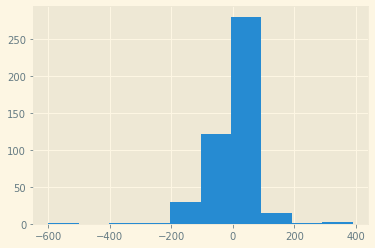

In [187]:
print(f'average profit of a negative trade: {copy_df[(copy_df.profit < 0) & (copy_df.profit > -400)].profit.mean():.2f}')
plt.hist(copy_df[(copy_df.profit > -1000)].profit.values)

In [188]:
copy_df[copy_df.profit < 0].groupby(by='typeHolding').describe()

position                                                  \
                      count        mean         std         min         25%   
typeHolding                                                                   
endPeriod              89.0  -10.202254  180.533941 -185.993164 -180.751561   
fatExtraProfit          2.0 -178.014951    2.983613 -180.124684 -179.069818   
lightCross             70.0   20.305659  179.239377 -186.089331 -179.003442   
lightCrossEmergent      2.0   -1.702582  247.227316 -176.518694  -89.110638   
stopLoss                1.0  181.568807         NaN  181.568807  181.568807   

                                                       openPrice              \
                           50%         75%         max     count        mean   
typeHolding                                                                    
endPeriod          -173.420139  179.349188  185.579261      89.0  111.298181   
fatExtraProfit     -178.014951 -176.960085 -175.905218       2.0  112.365896   
lightCross          172.394995  180.275035  184.066055      70.0  111.738260   
lightCrossEmergent   -1.702582   85.705474  173.113530       2.0  114.416784   
stopLoss            181.568807  181.568807  181.568807       1.0  110.151079   

                    ... closeIndex           profit                         \
                    ...        75%       max  count        mean        std   
typeHolding         ...                                                      
endPeriod           ...  515057.00  700329.0   89.0  -74.209025  62.461721   
fatExtraProfit      ...  487903.25  604047.0    2.0   -2.102137   0.750984   
lightCross          ...  514733.00  698022.0   70.0  -56.932808  38.064328   
lightCrossEmergent  ...  631665.50  635835.0    2.0  -18.932327  10.308635   
stopLoss            ...   56800.00   56800.0    1.0 -600.200000        NaN   

                                                                                
                           min         25%         50%         75%         max  
typeHolding                                                                     
endPeriod          -370.384422 -104.512820  -57.569544  -27.869532   -0.509514  
fatExtraProfit       -2.633163   -2.367650   -2.102137   -1.836624   -1.571111  
lightCross         -166.193035  -75.154901  -54.037553  -28.940234   -0.345004  
lightCrossEmergent  -26.221633  -22.576980  -18.932327  -15.287675  -11.643022  
stopLoss           -600.200000 -600.200000 -600.200000 -600.200000 -600.200000  

[5 rows x 64 columns]

In [189]:
copy_df.groupby(by='typeHolding').describe()

position                                                  \
                      count        mean         std         min         25%   
typeHolding                                                                   
endPeriod             129.0  -12.499030  180.047105 -185.993164 -180.751561   
fatExtraProfit         54.0   13.896887  181.081196 -183.803296 -179.242293   
lightCross             91.0   17.635497  179.217771 -186.089331 -178.965444   
lightCrossEmergent    176.0    2.254998  180.264137 -185.417154 -179.713828   
stopLoss                1.0  181.568807         NaN  181.568807  181.568807   

                                                       openPrice              \
                           50%         75%         max     count        mean   
typeHolding                                                                    
endPeriod          -173.420139  179.349188  186.627526     129.0  111.318020   
fatExtraProfit      174.212963  181.978147  185.182053      54.0  111.210824   
lightCross          172.134343  180.429742  184.066055      91.0  111.744089   
lightCrossEmergent  171.555530  180.579618  187.071020     176.0  111.322326   
stopLoss            181.568807  181.568807  181.568807       1.0  110.151079   

                    ... closeIndex           profit                         \
                    ...        75%       max  count        mean        std   
typeHolding         ...                                                      
endPeriod           ...   529998.0  700329.0  129.0  -32.841755  87.820281   
fatExtraProfit      ...   530450.5  688589.0   54.0   25.944598  18.574347   
lightCross          ...   537280.0  698022.0   91.0  -37.385066  49.887835   
lightCrossEmergent  ...   519762.0  702114.0  176.0   34.234865  38.161131   
stopLoss            ...    56800.0   56800.0    1.0 -600.200000        NaN   

                                                                                
                           min         25%         50%         75%         max  
typeHolding                                                                     
endPeriod          -370.384422  -76.919700  -31.003067   10.422810  320.284543  
fatExtraProfit       -2.633163   14.911690   21.773092   34.297556  102.679431  
lightCross         -166.193035  -68.609322  -42.190201   -3.081870   86.386545  
lightCrossEmergent  -26.221633   17.126716   25.723214   38.386782  390.235641  
stopLoss           -600.200000 -600.200000 -600.200000 -600.200000 -600.200000  

[5 rows x 64 columns]

In [190]:
copy_df.profit.cumsum().iloc[-1]

-812.4827598305284

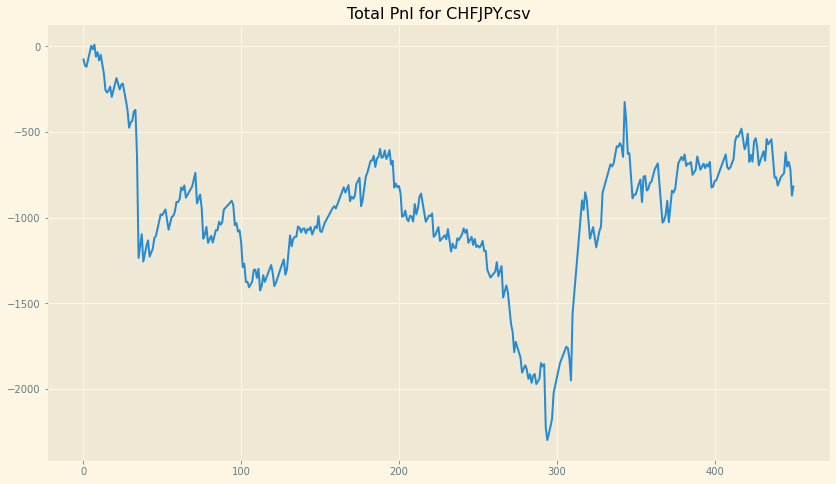

In [191]:
plt.figure(figsize=(14,8))
plt.style.use('Solarize_Light2')
plt.plot(copy_df.profit.cumsum())
plt.title(f'Total Pnl for {pairName}')
plt.show()